This code is implementation of the below paper:

 Controllable Variational Autoencoder

 in this code we implemented a VAE and then a Controllable VAE.

 After training, we take some random samples from our sample space and generate new images with them.

#Section 1 / without pid

In [ ]:
!rm -r checkpoints
!rm -r outputs
!rm -r results

rm: cannot remove 'checkpoints': No such file or directory
rm: cannot remove 'outputs': No such file or directory
rm: cannot remove 'results': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
# torch.cuda.set_device(0)
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

# from utils import cuda, grid2gif
# from model_batch import BetaVAE_H, BetaVAE_B,reparametrize
# from model_d128 import BetaVAE_H, BetaVAE_B,reparametrize
# from dataset import return_data
# from I_PID import PIDControl
# from PID import PIDControl
import matplotlib.pyplot as plt


In [ ]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __getitem__(self, index):
        return self.data_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)

batch_size = 64

def return_data():
    root = '/content/drive/MyDrive/kaggle/sh3_sc6_y32_x32_imgs.npz'
    # if not os.path.exists(root):
    #     import subprocess
    #     print('Now download dsprites-dataset')
    #     subprocess.call(['./download_dsprites.sh'])
    #     print('Finished')
    data = np.load(root, encoding='bytes')
    data = torch.from_numpy(data['imgs']).unsqueeze(1).float()
    train_kwargs = {'data_tensor':data}
    dset = CustomTensorDataset

    train_data = dset(**train_kwargs)
    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              # num_workers=num_workers,
                              pin_memory=True,
                              drop_last=True)

    data_loader = train_loader

    return data_loader,data


data_loader,imgs = return_data()


In [ ]:
print(len(imgs))

18432


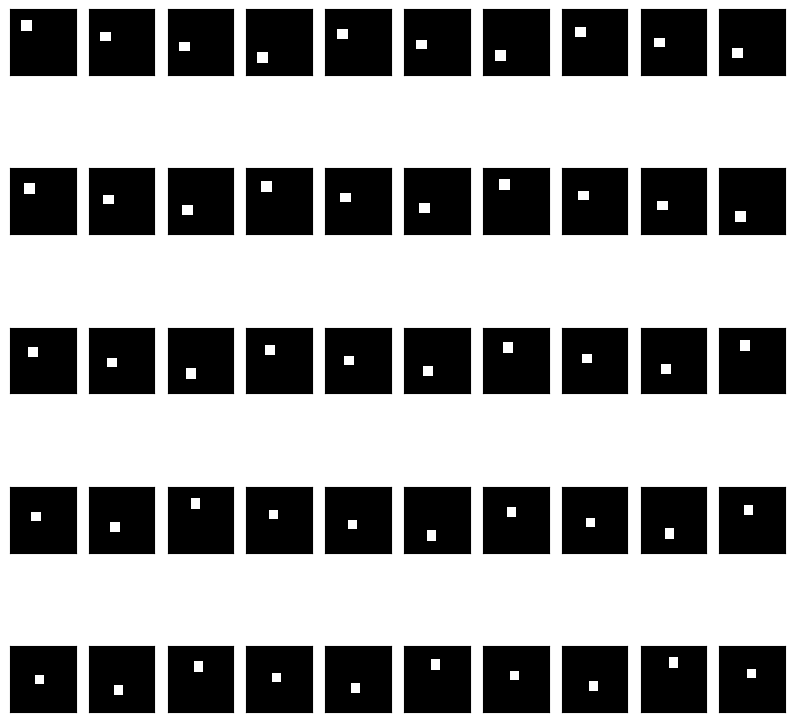

In [ ]:
def show_images_grid(imgs_, num_images=len(imgs)):
  ncols = 5
  nrows = 10
  _, axes = plt.subplots(ncols, nrows, figsize=(10, 10))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i*10][0,:,:], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')


show_images_grid(imgs)

In [ ]:
"""model.py"""

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable


def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps

class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017).
        input_dim + 2*padding - k_size)/stride + 1
    """

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),    # B, 32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),    # B, 32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),    # B, 64, 8, 8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),    # B, 64, 4, 4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 2, 1),   # B, 256, 2, 2
            nn.ReLU(True),
            View((-1, 256*2*2)),           # B, 256
            nn.Linear(256*2*2, 256),   # B, z_dim*2
            nn.Linear(256, z_dim*2),   # B, z_dim*2
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.Linear(256, 256*2*2),   # B, z_dim*2
            View((-1, 256, 2, 2)),             # B, 256, 2, 2
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4, 2, 1),  # B, 64, 4, 4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),   # B, 64, 8, 8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # B, 32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),   # B, 32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),   # B, nc, 64, 64
        )


        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()


model = BetaVAE_H()

In [ ]:
#!/usr/bin/env python3
# coding: utf-8

from math import exp

class PIDControl():
    """docstring for ClassName"""
    def __init__(self):
        """define them out of loop"""
        # self.exp_KL = exp_KL
        self.I_k1 = 0.0
        self.W_k1 = 0.0
        self.e_k1 = 0.0

    def _Kp_fun(self, Err, scale=1):
        return 1.0/(1.0 + float(scale)*exp(Err))


    def pid(self, exp_KL, kl_loss, Kp=0.001, Ki=-0.001, Kd=0.01):
        """
        position PID algorithm
        Input: KL_loss
        return: weight for KL loss, beta
        """
        error_k = exp_KL - kl_loss
        ## comput U as the control factor
        Pk = Kp * self._Kp_fun(error_k)
        Ik = self.I_k1 + Ki * error_k
        # Dk = (error_k - self.e_k1) * Kd

        ## window up for integrator
        if self.W_k1 < 0 and self.W_k1 >= 1:
            Ik = self.I_k1

        Wk = Pk + Ik
        self.W_k1 = Wk
        self.I_k1 = Ik
        self.e_k1 = error_k

        ## min and max value
        if Wk > 1:
            Wk = 1.0
        if Wk < 0:
            Wk = 0.0

        return Wk, error_k


In [ ]:
def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        x_recon = F.sigmoid(x_recon)
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld


In [ ]:
def cuda(tensor, uses_cuda):
    return tensor.cuda() if uses_cuda else tensor

In [ ]:
# def generate_random_samples():
#   num_random_samples = len(imgs)  # Define the number of random samples you want to generate
#   random_z = torch.randn(num_random_samples, 10)
#   return random_z

# random_z = generate_random_samples()
# random_z.to('cpu')

In [ ]:
"""solver.py"""


import torch
# torch.cuda.set_device(0)
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

# from utils import cuda, grid2gif
# # from model_batch import BetaVAE_H, BetaVAE_B,reparametrize
# from model_d128 import BetaVAE_H, BetaVAE_B,reparametrize
# from dataset import return_data
# # from I_PID import PIDControl
# from PID import PIDControl

import matplotlib.pyplot as plt

def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        x_recon = F.sigmoid(x_recon)
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld


class DataGather(object):
    def __init__(self):
        self.data = self.get_empty_data_dict()

    def get_empty_data_dict(self):
        return dict(iter=[],
                    recon_loss=[],
                    total_kld=[],
                    dim_wise_kld=[],
                    mean_kld=[],
                    mu=[],
                    var=[],
                    images=[], beta=[])

    def insert(self, **kwargs):
        for key in kwargs:
            self.data[key].append(kwargs[key])

    def flush(self):
        self.data = self.get_empty_data_dict()


class Solver(object):
    def __init__(self, args, pid, kl_loss_=8):
        self.use_cuda = torch.cuda.is_available()
        self.max_iter = 1000
        self.global_iter = 0

        self.z_dim = 100
        self.beta = 4
        self.gamma = 1000
        self.C_max = 25
        self.C_max_org = 25
        self.C_stop_iter = 5e5
        self.objective = 'H'
        self.model = model
        self.lr = 1e-4
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.KL_loss = kl_loss_
        self.pid_fixed = False
        self.is_PID = pid
        self.model_name = 'main'

        # if args.dataset.lower() == 'dsprites':
        self.nc = 1
        self.decoder_dist = 'bernoulli'
        # elif args.dataset.lower() == '3dchairs':
        #     self.nc = 3
        #     self.decoder_dist = 'gaussian'
        # elif args.dataset.lower() == 'celeba':
        #     self.nc = 3
        #     self.decoder_dist = 'gaussian'
        # else:
        #     raise NotImplementedError

        # if args.model == 'H':
        net = BetaVAE_H
        # elif args.model == 'B':
        #     net = BetaVAE_B
        # else:
        #     raise NotImplementedError('only support model H or B')
        ## load model
        self.net = cuda(net(self.z_dim, self.nc), self.use_cuda)
        self.optim = optim.Adam(self.net.parameters(), lr=self.lr,
                                    betas=(self.beta1, self.beta2))

        self.viz_name = 'main'
        self.viz_port = 8097
        self.viz_on = False
        self.win_recon = None
        self.win_beta = None
        self.win_kld = None
        self.win_mu = None
        self.win_var = None
        if self.viz_on:
            self.viz = visdom.Visdom(port=self.viz_port)

        self.ckpt_dir = os.path.join('checkpoints', 'main')
        if not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir, exist_ok=True)
        self.ckpt_name = 'last'
        if self.ckpt_name is not None:
            self.load_checkpoint(self.ckpt_name)

        self.save_output = True
        self.output_dir = os.path.join('outputs', 'main')
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir, exist_ok=True)

        self.gather_step = 10000
        self.display_step = 10000
        self.save_step = 10000

        self.dset_dir =  'data'
        # self.dataset = args.dataset
        self.batch_size = 64
        self.data_loader, _ = return_data()

        self.gather = DataGather()
        self.gather2 = DataGather()


    def train(self):
        self.net_mode(train=True)
        self.C_max = Variable(cuda(torch.FloatTensor([self.C_max]), self.use_cuda))
        out = False
        epochs = 120
        pbar = tqdm(range(epochs))
        ## write log to log file
        outfile = os.path.join(self.ckpt_dir, "train.log")
        fw_log = open(outfile, "w")

        ## init PID control
        PID = PIDControl()
        Kp = 0.01
        Ki = -0.0001
        Kd = 0.0
        fw_log.write("Kp:{0:.5f} Ki: {1:.6f}\n".format(Kp, Ki))
        fw_log.flush()

        recon_loss_arr = []
        kl_loss_arr = []
        beta_vae_loss_arr = []

        for i in pbar:
            recon_loss_init = 0
            kl_loss_init = 0
            beta_vae_loss_init = 0
            number_of_batch = 0
            for x in self.data_loader:
                number_of_batch += 1
                # print('shape>>', x.size())
                self.global_iter += 1
                pbar.update(1)

                x = Variable(cuda(x, self.use_cuda))
                x_recon, mu, logvar = self.net(x)
                recon_loss = reconstruction_loss(x, x_recon, self.decoder_dist)
                total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
                recon_loss_init += recon_loss.item()
                kl_loss_init += total_kld.item()

                if self.is_PID:
                    # print(self.beta)
                    self.beta, _ = PID.pid(self.KL_loss, total_kld.item(), Kp, Ki, Kd)
                    beta_vae_loss = recon_loss + self.beta * total_kld
                else:
                    beta_vae_loss = recon_loss + 1.0 * total_kld
                    ### tricks for C
                    # C = torch.clamp(self.C_max/self.C_stop_iter*self.global_iter, 0, self.C_max.data[0])
                    # beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()
                beta_vae_loss_init +=  beta_vae_loss.item()
                self.optim.zero_grad()
                beta_vae_loss.backward()
                self.optim.step()
            kl_loss_arr.append(kl_loss_init / number_of_batch)
            recon_loss_arr.append(recon_loss_init / number_of_batch)
            beta_vae_loss_arr.append(beta_vae_loss_init / number_of_batch)

        pbar.write("[Training Finished]")
        pbar.close()
        fw_log.close()
        return recon_loss_arr, kl_loss_arr, beta_vae_loss_arr


    def _test_model(self):
        print('******--testing model now--****')
        test_path = os.path.join('results', self.model_name)
        if not os.path.exists(test_path):
                os.makedirs(test_path)

        predict_path = os.path.join(test_path, 'testing/predict-25')
        ground_path = os.path.join(test_path, 'ground/ground_truth-25')
        image_path = [predict_path, ground_path]

        for path in image_path:
            if not os.path.exists(path):
                os.makedirs(path)
        ## evaluate the result
        self.net_mode(train=False)
        self.net.to('cuda')

        num_random_samples = len(imgs)  # Define the number of random samples you want to generate
        random_z = torch.randn(num_random_samples, self.z_dim)
        if self.use_cuda:
            random_z = random_z.cuda()

        # Decode the random inputs
        random_reconstructions = F.sigmoid(self.net._decode(Variable(random_z.to('cuda')))).data
        print(random_reconstructions.shape)
        if self.use_cuda:
            random_reconstructions = random_reconstructions.cpu()

        # ids = 0
        # batch = 0
        # num_image = 5
        # for x in self.data_loader:
        #     batch += 1
        #     x = Variable(cuda(x, self.use_cuda))
        #     x_recon, _, _ = self.net(x)
        #     samples = F.sigmoid(x_recon).data
        #     batch_size = samples.size(0)
        #     # save_image(samples, filename=os.path.join(image_path[0], 'recontruct_{}.eps'.format(batch)),nrow=num_image,pad_value=1)
        #     # save_image(x, filename=os.path.join(image_path[1], 'recontruct_{}.eps'.format(batch)),nrow=num_image,pad_value=1)
        #     # if batch >= 10:
        #     #     break
        ids = 0
        for b in range(len(imgs)):
            ids += 1
            predict_image_path = os.path.join(image_path[0], 'predict_{}.jpg'.format(ids))
            ground_image_path = os.path.join(image_path[1], 'ground_{}.jpg'.format(ids))

            save_image(random_reconstructions[b], predict_image_path)
            save_image(imgs[b], ground_image_path)

        return random_reconstructions

    def net_mode(self, train):
        if not isinstance(train, bool):
            raise('Only bool type is supported. True or False')

        if train:
            self.net.train()
        else:
            self.net.eval()

    def save_checkpoint(self, filename, silent=True):
        model_states = {'net':self.net.state_dict(),}
        optim_states = {'optim':self.optim.state_dict(),}
        win_states = {'recon':self.win_recon,
                      'beta': self.win_beta,
                      'kld':self.win_kld,
                      'mu':self.win_mu,
                      'var':self.win_var,}
        states = {'iter':self.global_iter,
                  'win_states':win_states,
                  'model_states':model_states,
                  'optim_states':optim_states}

        file_path = os.path.join(self.ckpt_dir, filename)
        with open(file_path, mode='wb+') as f:
            torch.save(states, f)
        if not silent:
            print("=> saved checkpoint '{}' (iter {})".format(file_path, self.global_iter))


    def load_checkpoint(self, filename):
        file_path = os.path.join(self.ckpt_dir, filename)
        if os.path.isfile(file_path):
            checkpoint = torch.load(file_path)
            self.global_iter = checkpoint['iter']
            self.win_recon = checkpoint['win_states']['recon']
            self.win_kld = checkpoint['win_states']['kld']
            self.win_var = checkpoint['win_states']['var']
            self.win_mu = checkpoint['win_states']['mu']
            self.net.load_state_dict(checkpoint['model_states']['net'])
            self.optim.load_state_dict(checkpoint['optim_states']['optim'])
            print("=> loaded checkpoint '{} (iter {})'".format(file_path, self.global_iter))
        else:
            print("=> no checkpoint found at '{}'".format(file_path))




In [ ]:
import argparse




def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser(description='toy Beta-VAE')
parser.add_argument('--train', default=True, type=str2bool, help='train or traverse')
parser.add_argument('--seed', default=1, type=int, help='random seed')
parser.add_argument('--cuda', default=True, type=str2bool, help='enable cuda')

parser.add_argument('--max_iter', default=1e6, type=float, help='maximum training iteration')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--limit', default=3, type=float, help='traverse limits')
parser.add_argument('--KL_loss', default=25, type=float, help='KL KL_divergence')
parser.add_argument('--pid_fixed', default=False, type=str2bool, help='if fixed PID or dynamic')
parser.add_argument('--is_PID', default=True, type=str2bool, help='if use pid or not')
parser.add_argument('--z_dim', default=100, type=int, help='dimension of the representation z')
parser.add_argument('--beta', default=4, type=float, help='beta parameter for KL-term in original beta-VAE')
parser.add_argument('--objective', default='H', type=str, help='beta-vae objective proposed in Higgins et al. or Burgess et al. H/B')
parser.add_argument('--model', default='H', type=str, help='model proposed in Higgins et al. or Burgess et al. H/B')
parser.add_argument('--gamma', default=1000, type=float, help='gamma parameter for KL-term in understanding beta-VAE')
parser.add_argument('--C_max', default=25, type=float, help='capacity parameter(C) of bottleneck channel')
parser.add_argument('--C_stop_iter', default=5e5, type=float, help='when to stop increasing the capacity')
parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--beta1', default=0.9, type=float, help='Adam optimizer beta1')
parser.add_argument('--beta2', default=0.999, type=float, help='Adam optimizer beta2')

parser.add_argument('--dset_dir', default='data', type=str, help='dataset directory')
parser.add_argument('--dataset', default='CelebA', type=str, help='dataset name')
parser.add_argument('--image_size', default=64, type=int, help='image size. now only (64,64) is supported')
parser.add_argument('--num_workers', default=4, type=int, help='dataloader num_workers')

parser.add_argument('--viz_on', default=True, type=str2bool, help='enable visdom visualization')
parser.add_argument('--viz_name', default='main', type=str, help='visdom env name')
parser.add_argument('--viz_port', default=8097, type=str, help='visdom port number')
parser.add_argument('--save_output', default=True, type=str2bool, help='save traverse images and gif')
parser.add_argument('--output_dir', default='outputs', type=str, help='output directory')

parser.add_argument('--gather_step', default=10000, type=int, help='numer of iterations after which data is gathered for visdom')
parser.add_argument('--display_step', default=10000, type=int, help='number of iterations after which loss data is printed and visdom is updated')
parser.add_argument('--save_step', default=10000, type=int, help='number of iterations after which a checkpoint is saved')

parser.add_argument('--ckpt_dir', default='checkpoints', type=str, help='checkpoint directory')
parser.add_argument('--ckpt_name', default='last', type=str, help='load previous checkpoint. insert checkpoint filename')

args = parser.parse_known_args()

In [ ]:
net = Solver(args,pid=False)

=> no checkpoint found at 'checkpoints/main/last'


In [ ]:
recon_loss_arr, kl_loss_arr, beta_vae_loss_arr = net.train()

100%|██████████| 120/120 [05:16<00:00,  2.64s/it]

[Training Finished]


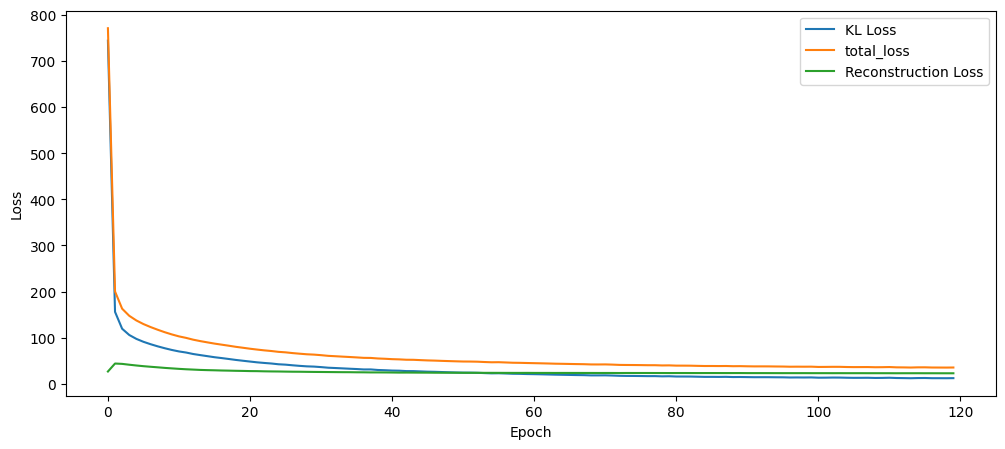

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(recon_loss_arr, label='KL Loss')
plt.plot(beta_vae_loss_arr, label='total_loss')
plt.plot(kl_loss_arr, label='Reconstruction Loss')
# plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

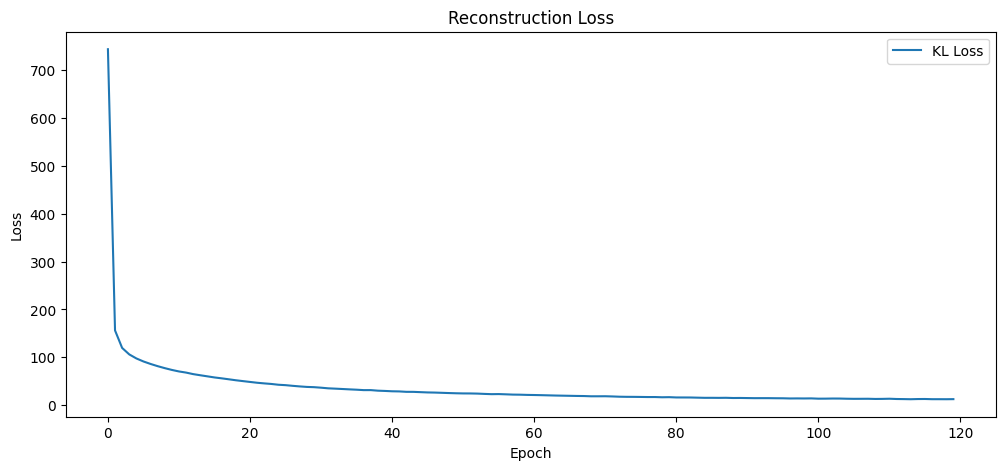

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(recon_loss_arr, label='KL Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

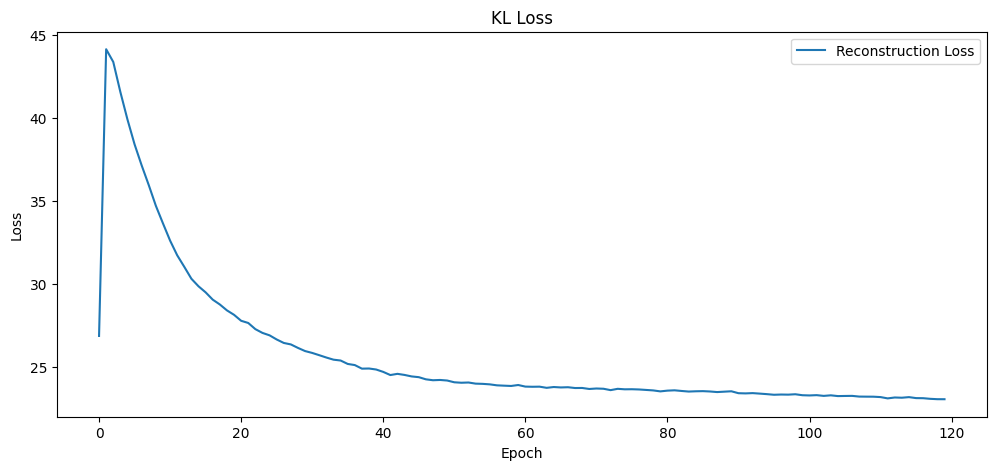

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(kl_loss_arr, label='Reconstruction Loss')
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

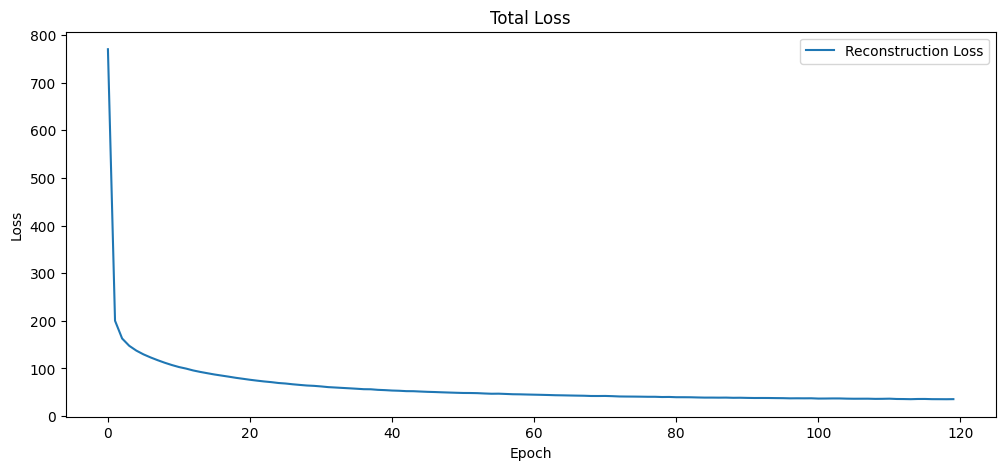

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(beta_vae_loss_arr, label='Reconstruction Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
random_reconstruction = net._test_model()

******--testing model now--****
torch.Size([18432, 1, 64, 64])


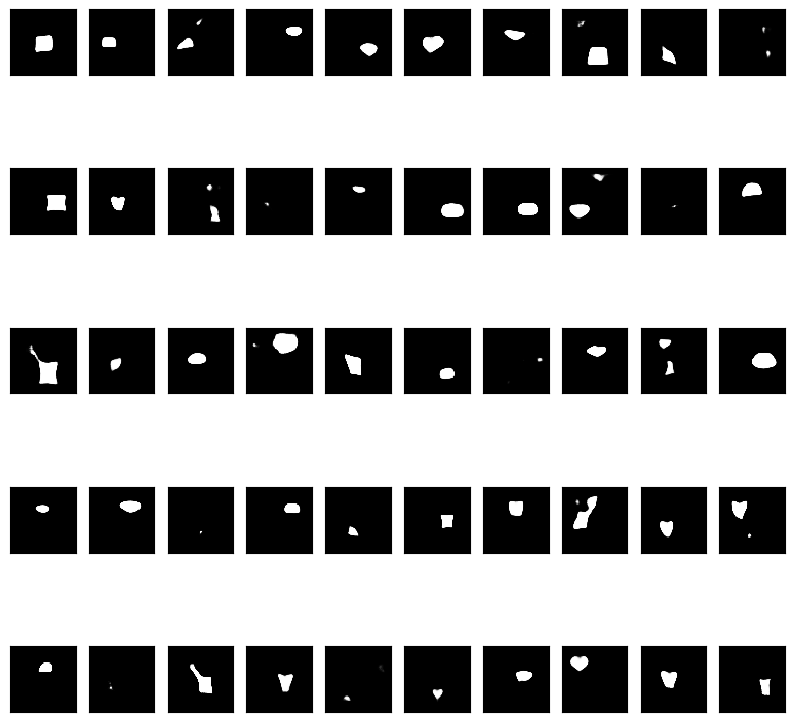

In [ ]:
show_images_grid(random_reconstruction)

In [ ]:
!pip install pytorch-fid

In [ ]:
from torchvision import transforms
from pytorch_fid import fid_score
from PIL import Image
import os

def calculate_fid_with_pytorch_fid():
    batch_size=50
    device='cuda'
    # Function to convert tensor to a list of images
    # def tensor_to_images(tensor):
    #     images = []
    #     for img in tensor:
    #         # Handle single-channel and multi-channel images differently
    #         if img.shape[0] == 1:  # Grayscale image, single channel
    #             img = img.squeeze(0)  # Remove channel dimension
    #             img_pil = transforms.ToPILImage()(img).convert("L")  # Convert to PIL image
    #         else:  # RGB image, multiple channels
    #             img_pil = transforms.ToPILImage()(img).convert("RGB")
    #         images.append(img_pil)
    #     return images

    # # Convert tensors to lists of images
    # images1 = tensor_to_images(tensor1)
    # images2 = tensor_to_images(tensor2)

    # # # Save the images temporarily
    # os.makedirs("temp_images1", exist_ok=True)
    # os.makedirs("temp_images2", exist_ok=True)
    # for i, img in enumerate(images1):
    #     img.save(f"temp_images1/{i}.png")
    # for i, img in enumerate(images2):
    #     img.save(f"temp_images2/{i}.png")

    # Calculate FID
    fid = fid_score.calculate_fid_given_paths(["results/main/ground/ground_truth-25", "results/main/testing/predict-25"],
                                              batch_size=batch_size,
                                              device='cuda',
                                              dims=2048)
    return fid

# Example usage:
fid_score = calculate_fid_with_pytorch_fid()
print("FID Score:", fid_score)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 193MB/s]
100%|██████████| 369/369 [01:14<00:00,  4.96it/s]


FID Score: 65.95544898218215


#Section 2 / PID + kl_loss = 8

In [ ]:
!rm -r checkpoints
!rm -r outputs
!rm -r results

In [ ]:
net = Solver(args,pid=True, kl_loss_=8)

=> no checkpoint found at 'checkpoints/main/last'


In [ ]:
recon_loss_arr_8, kl_loss_arr_8, beta_vae_loss_arr_8 = net.train()

100%|██████████| 120/120 [05:32<00:00,  2.77s/it]

[Training Finished]


In [ ]:
# plt.figure(figsize=(12, 5))
# plt.plot(recon_loss_arr_8, label='KL Loss')
# plt.plot(beta_vae_loss_arr_8, label='total_loss')
# plt.plot(kl_loss_arr_8, label='Reconstruction Loss')
# # plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

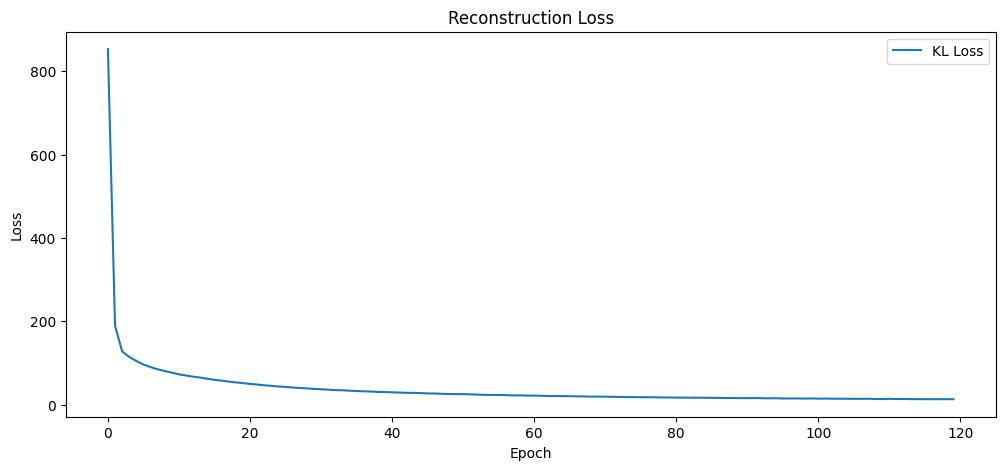

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(recon_loss_arr_8, label='KL Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

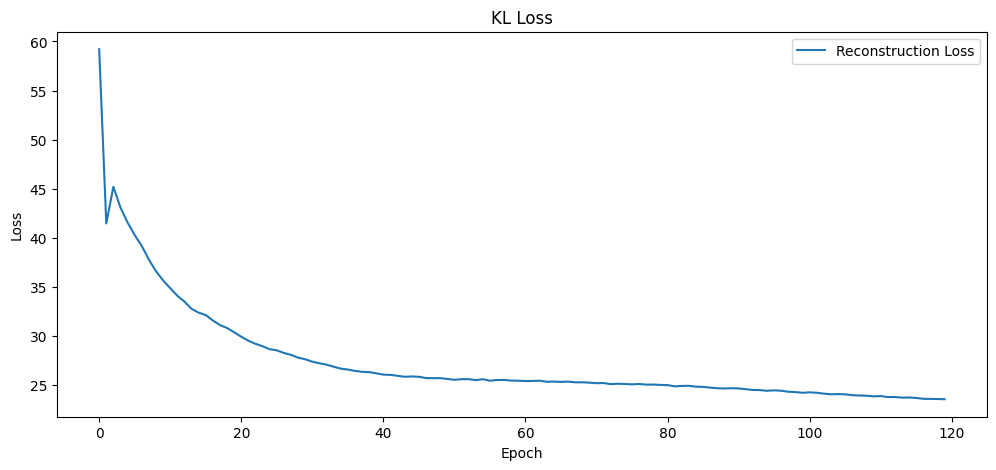

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(kl_loss_arr_8, label='Reconstruction Loss')
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

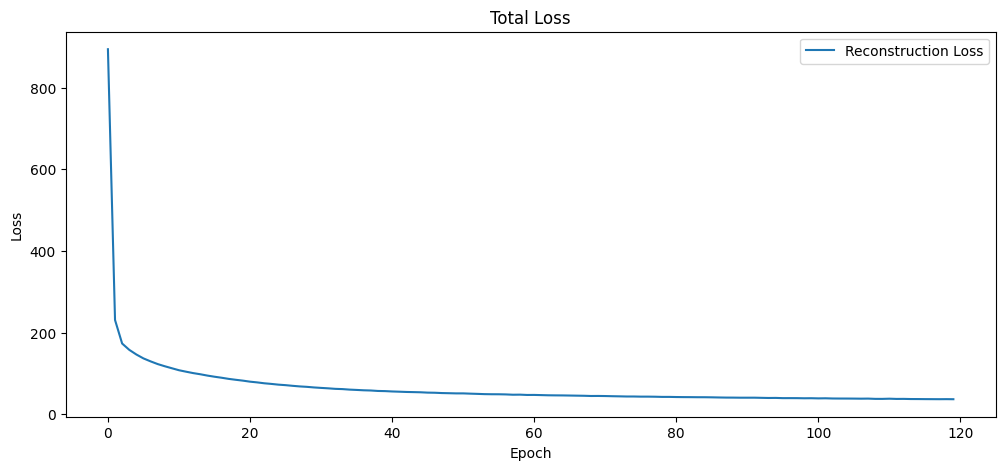

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(beta_vae_loss_arr_8, label='Reconstruction Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
random_reconstruction = net._test_model()

******--testing model now--****
torch.Size([18432, 1, 64, 64])


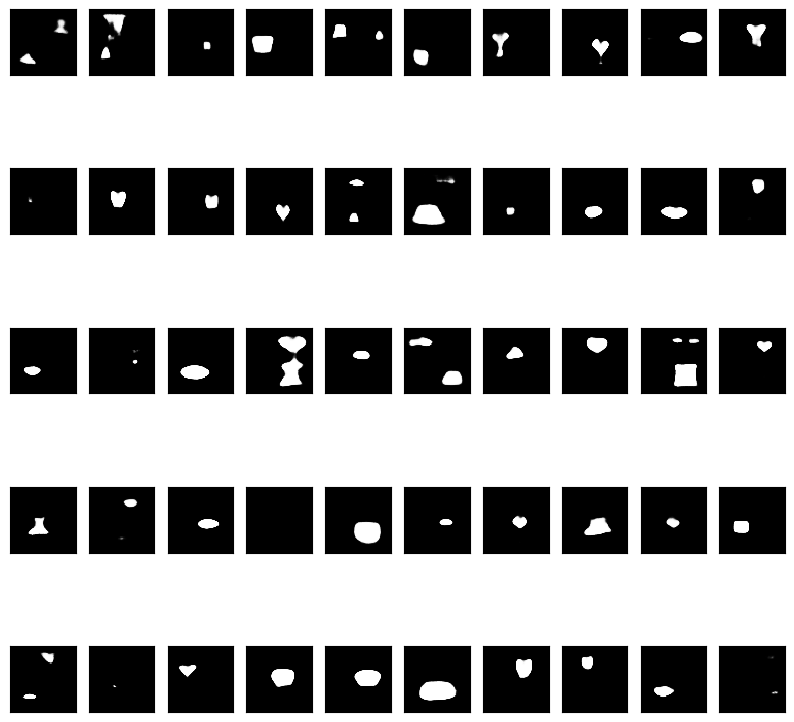

In [ ]:
show_images_grid(random_reconstruction)

In [ ]:
!pip install pytorch-fid

In [ ]:
from torchvision import transforms
from pytorch_fid import fid_score
from PIL import Image
import os

def calculate_fid_with_pytorch_fid():
    batch_size=50
    device='cuda'
    # Function to convert tensor to a list of images
    # def tensor_to_images(tensor):
    #     images = []
    #     for img in tensor:
    #         # Handle single-channel and multi-channel images differently
    #         if img.shape[0] == 1:  # Grayscale image, single channel
    #             img = img.squeeze(0)  # Remove channel dimension
    #             img_pil = transforms.ToPILImage()(img).convert("L")  # Convert to PIL image
    #         else:  # RGB image, multiple channels
    #             img_pil = transforms.ToPILImage()(img).convert("RGB")
    #         images.append(img_pil)
    #     return images

    # # Convert tensors to lists of images
    # images1 = tensor_to_images(tensor1)
    # images2 = tensor_to_images(tensor2)

    # # # Save the images temporarily
    # os.makedirs("temp_images1", exist_ok=True)
    # os.makedirs("temp_images2", exist_ok=True)
    # for i, img in enumerate(images1):
    #     img.save(f"temp_images1/{i}.png")
    # for i, img in enumerate(images2):
    #     img.save(f"temp_images2/{i}.png")

    # Calculate FID
    fid = fid_score.calculate_fid_given_paths(["results/main/ground/ground_truth-25", "results/main/testing/predict-25"],
                                              batch_size=batch_size,
                                              device='cuda',
                                              dims=2048)
    return fid

# Example usage:
fid_score = calculate_fid_with_pytorch_fid()
print("FID Score:", fid_score)

100%|██████████| 369/369 [01:14<00:00,  4.95it/s]


FID Score: 67.34857619834864


#Section 2 / PID + kl_loss = 14

In [ ]:
!rm -r checkpoints
!rm -r outputs
!rm -r results

In [ ]:
net = Solver(args,pid=True, kl_loss_=14)

=> no checkpoint found at 'checkpoints/main/last'


In [ ]:
recon_loss_arr_14, kl_loss_arr_14, beta_vae_loss_arr_14 = net.train()

100%|██████████| 120/120 [05:30<00:00,  2.76s/it]

[Training Finished]


In [ ]:
# plt.figure(figsize=(12, 5))
# plt.plot(recon_loss_arr_14, label='KL Loss')
# plt.plot(beta_vae_loss_arr_14, label='total_loss')
# plt.plot(kl_loss_arr_14, label='Reconstruction Loss')
# # plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

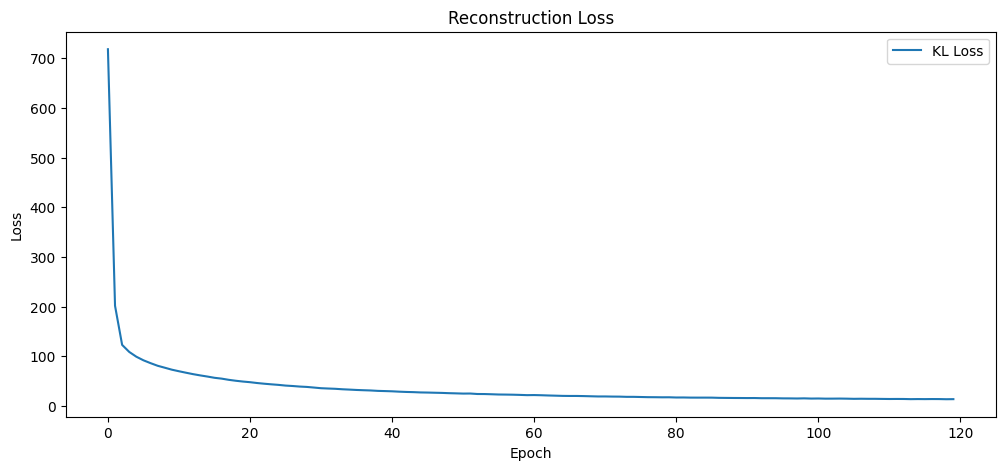

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(recon_loss_arr_14, label='KL Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

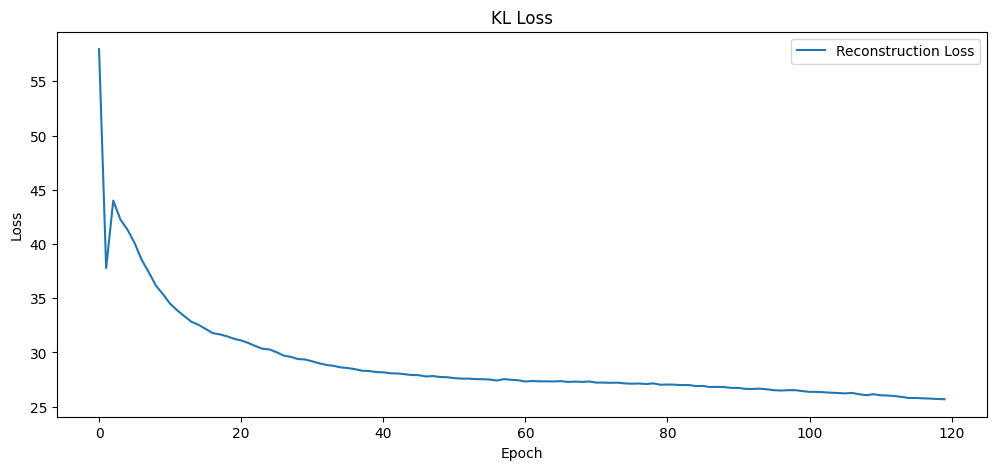

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(kl_loss_arr_14, label='Reconstruction Loss')
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

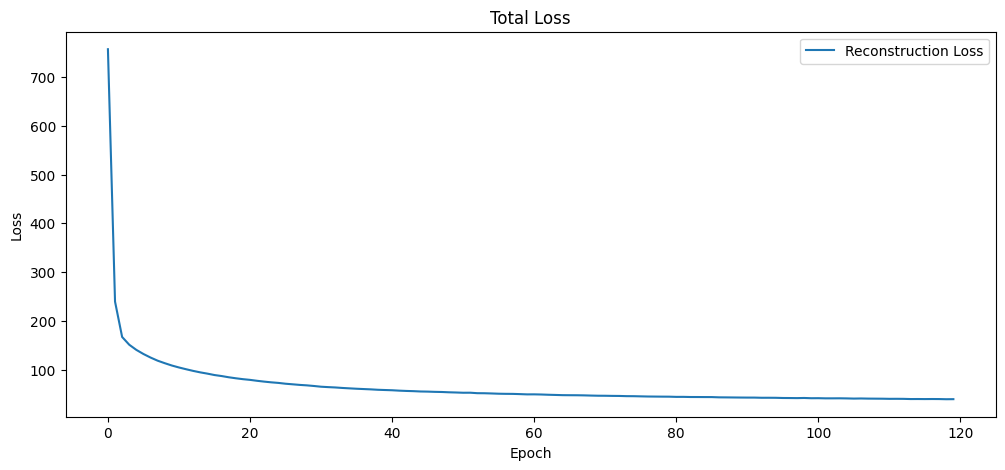

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(beta_vae_loss_arr_14, label='Reconstruction Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
random_reconstruction = net._test_model()

******--testing model now--****
torch.Size([18432, 1, 64, 64])


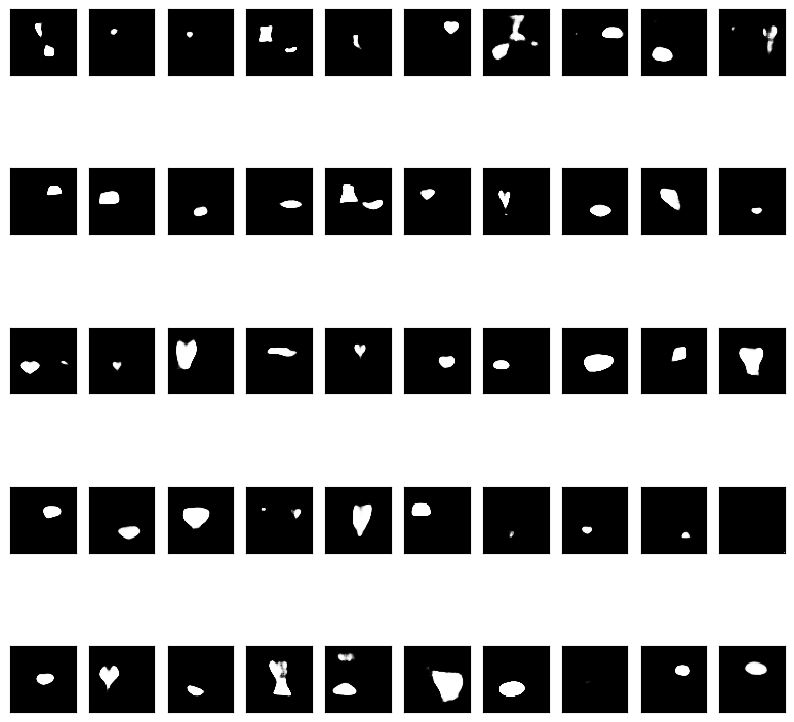

In [ ]:
show_images_grid(random_reconstruction)

In [ ]:
!pip install pytorch-fid

In [ ]:
from torchvision import transforms
from pytorch_fid import fid_score
from PIL import Image
import os

def calculate_fid_with_pytorch_fid():
    batch_size=50
    device='cuda'
    # Function to convert tensor to a list of images
    # def tensor_to_images(tensor):
    #     images = []
    #     for img in tensor:
    #         # Handle single-channel and multi-channel images differently
    #         if img.shape[0] == 1:  # Grayscale image, single channel
    #             img = img.squeeze(0)  # Remove channel dimension
    #             img_pil = transforms.ToPILImage()(img).convert("L")  # Convert to PIL image
    #         else:  # RGB image, multiple channels
    #             img_pil = transforms.ToPILImage()(img).convert("RGB")
    #         images.append(img_pil)
    #     return images

    # # Convert tensors to lists of images
    # images1 = tensor_to_images(tensor1)
    # images2 = tensor_to_images(tensor2)

    # # # Save the images temporarily
    # os.makedirs("temp_images1", exist_ok=True)
    # os.makedirs("temp_images2", exist_ok=True)
    # for i, img in enumerate(images1):
    #     img.save(f"temp_images1/{i}.png")
    # for i, img in enumerate(images2):
    #     img.save(f"temp_images2/{i}.png")

    # Calculate FID
    fid = fid_score.calculate_fid_given_paths(["results/main/ground/ground_truth-25", "results/main/testing/predict-25"],
                                              batch_size=batch_size,
                                              device='cuda',
                                              dims=2048)
    return fid

# Example usage:
fid_score = calculate_fid_with_pytorch_fid()
print("FID Score:", fid_score)

100%|██████████| 369/369 [01:14<00:00,  4.97it/s]


FID Score: 71.39273579230691


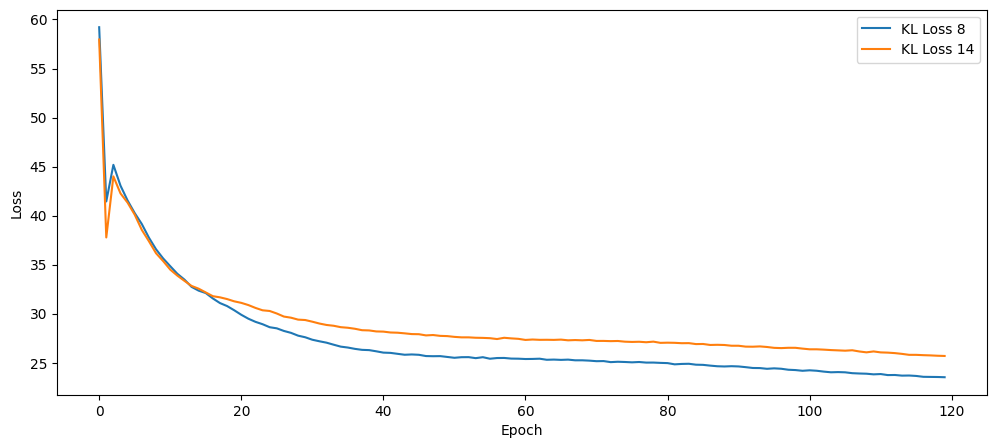

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(kl_loss_arr_8, label='KL Loss 8')
plt.plot(kl_loss_arr_14, label='KL Loss 14')
# plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()